In [1]:
# load libraries

import glob
import os
import pandas as pd
import numpy as np
import nltk
from nltk import word_tokenize
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# let's have a look at the files

path = r'C:\Users\sonja tilly.ABERDEEN\text_docs\*'

files = glob.glob(path)

files[0:10]

['C:\\Users\\sonja tilly.ABERDEEN\\text_docs\\Aberdeen.txt',
 'C:\\Users\\sonja tilly.ABERDEEN\\text_docs\\Alliance Bernstein.txt',
 'C:\\Users\\sonja tilly.ABERDEEN\\text_docs\\Allianz.txt',
 'C:\\Users\\sonja tilly.ABERDEEN\\text_docs\\Amundi.txt',
 'C:\\Users\\sonja tilly.ABERDEEN\\text_docs\\Aviva.txt',
 'C:\\Users\\sonja tilly.ABERDEEN\\text_docs\\AXA.txt',
 'C:\\Users\\sonja tilly.ABERDEEN\\text_docs\\Barclays.txt',
 'C:\\Users\\sonja tilly.ABERDEEN\\text_docs\\BlackRock.txt',
 'C:\\Users\\sonja tilly.ABERDEEN\\text_docs\\BlueBay.txt',
 'C:\\Users\\sonja tilly.ABERDEEN\\text_docs\\BNP Paribas.txt']

In [3]:
# let's read in the files and append to a list of lists

list_of_lists = []

for file in files:
    text_file = open(file)
    lines = text_file.readlines()
    list_of_lists.append(lines)
    text_file.close()

In [4]:
list_of_lists[0][:5]

['Aberdeen\n',
 'Economic Outlook – January 2018\n',
 'Monthly highlights: Global economic strength to continue in 2018\n',
 'The global economy showed no sign of losing any momentum\n',
 'in 2017 Q4 and is heading into 2018 in a healthy state. We have\n']

In [5]:
# extract list of file company names

list_of_names = []

for f in files:
    head, tail = os.path.split(f)
    name = os.path.splitext(os.path.basename(tail))[0]
    list_of_names.append(name)
    
len(list_of_names)

50

In [41]:
# load nltk's English stopwords as 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
more_stopwords = ['and', 'to', 'the', 'we', 'of', 'in', 'are', 'on', 'stephan', 'market',
                 'year', 'investment', 'investor', 'economy', 'bank', 'portfolio', 'analyst',
                 'stock', 'manager', 'outlook']
stopwords.extend(more_stopwords)
print(stopwords[0:10])

# create tokenizer that picks out sequences of alphanumeric characters as tokens and drops everything else
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

from nltk import pos_tag

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [42]:
# tidy up list of lists

def tidy_up(temp0):
    temp1 = [[t.lower() for t in l] for l in temp0]
    temp2 = [[t.replace('\n','') for t in l] for l in temp1]
    temp3 = [[t.replace('\r','') for t in l] for l in temp2]
    temp4 = [[pos_tag(tokenizer.tokenize(t)) for t in l] for l in temp3]
    return temp4

In [43]:
# create function to create list of sentences

def raw_text(lol):
    temp = []
    for i in lol:
        sent = " ".join(str(item) for item in i)
        temp.append(sent)
    return temp

In [44]:
tokens = tidy_up(list_of_lists)

tokens[0][1]

[('economic', 'JJ'), ('outlook', 'NN'), ('january', 'NN'), ('2018', 'CD')]

In [45]:
# extract nouns

from nltk import pos_tag

nouns = []

for t in tokens:
    tmp = []
    for l in t:
        for token, pos in l:
            if pos.startswith('N'):
                tmp.append(token)
            
    nouns.append(tmp) 



In [46]:
nouns[0][0:10]

['aberdeen',
 'outlook',
 'january',
 'highlights',
 'strength',
 'economy',
 'sign',
 'momentum',
 'q4',
 'state']

In [47]:
# load nltk's Lemmatizer

from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()    

In [48]:
# lemmatize tokens

lems = []

for lst in nouns:
    temp = []
    for l in lst:
        st = wordnet_lemmatizer.lemmatize(l)
        temp.append(st)
    lems.append(temp) 

In [49]:
lems[0][0:10]

['aberdeen',
 'outlook',
 'january',
 'highlight',
 'strength',
 'economy',
 'sign',
 'momentum',
 'q4',
 'state']

In [50]:
lems_sent = raw_text(lems)

In [51]:
# remove stopwords from stems

clean_lems = [[i for i in l.split() if i not in stopwords] for l in lems_sent]
clean_lems[0][0:10]


['aberdeen',
 'january',
 'highlight',
 'strength',
 'sign',
 'momentum',
 'q4',
 'state',
 'forecast',
 'growth']

In [52]:
corpus = raw_text(clean_lems)
corpus[0][0:200]

'aberdeen january highlight strength sign momentum q4 state forecast growth percentage point purchasing index pmi level month trade prospect commodity price manufacturer commodity producer growth whole'

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# try Word Frequencies with TfidfVectorizer

# list text

def tfidf_vectorizer(text):
          
    # create the transform
    vectorizer = TfidfVectorizer()    
        
    # fit and encode text
    vector = vectorizer.fit_transform(text)

    # summarize encoded vector
    #print(vector.shape)
    array = vector.toarray()
        
    return array

In [54]:
text_array = tfidf_vectorizer(corpus)

In [55]:
# reduce data to 2 dimensions

from sklearn.decomposition import PCA

pca = PCA(n_components=2)

red = pca.fit_transform(text_array)

red_df = pd.DataFrame(red, columns=['X','Y'])


In [56]:
pca.explained_variance_

array([ 0.04398037,  0.04175502])

In [57]:
# set up kmeans algorithm

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

def clusterKMeans(k):
    clusterer = KMeans(n_clusters=k, random_state=47).fit(red_df)
    centroids = clusterer.cluster_centers_
    labels = clusterer.labels_
    score = silhouette_score(red_df, clusterer.labels_, metric='euclidean')
    samples_score = silhouette_samples(red_df, clusterer.labels_, metric='euclidean')
    return centroids, labels, score, samples_score

for i in range(2,8):
    centroids, labels, score, samples_score = clusterKMeans(i)
    print("The silhouette score for "+ str(i) + " clusters is: {:.3}.".format(score))

The silhouette score for 2 clusters is: 0.34.
The silhouette score for 3 clusters is: 0.401.
The silhouette score for 4 clusters is: 0.41.
The silhouette score for 5 clusters is: 0.404.
The silhouette score for 6 clusters is: 0.393.
The silhouette score for 7 clusters is: 0.408.


In [58]:

for i in range(4,5):
    centroids, labels, score, samples_score = clusterKMeans(i)
    
red_df['Cluster'] = labels

#red_df.index = list_of_names

red_df["Names"] = list_of_names

red_df.head()

,X,Y,Cluster,Names
0,-0.309786,0.214671,0,Aberdeen
1,-0.385521,0.028064,0,Alliance Bernstein
2,0.052134,-0.090269,1,Allianz
3,-0.178363,-0.180541,1,Amundi
4,-0.083849,0.084610,3,Aviva


In [59]:
#add centroid coordinates for each cluster

centroidsx = {0:centroids[0:1,0], 1:centroids[1:2, 0], 2:centroids[2:3, 0], 3:centroids[3:4, 0],
             4:centroids[4:5, 0], 5:centroids[5:6, 0], 6:centroids[6:7, 0]}

centroidsy = {0:centroids[0:1,1], 1:centroids[1:2, 1], 2:centroids[2:3, 1], 3:centroids[3:4, 1],
             4:centroids[4:5, 1], 5:centroids[5:6, 1], 6:centroids[6:7, 1]}

red_df['Centroidx'] = red_df['Cluster'].map(centroidsx)

red_df['Centroidy'] = red_df['Cluster'].map(centroidsy)

red_df.tail()


,X,Y,Cluster,Names,Centroidx,Centroidy
45,-0.321040,0.106232,0,Standard Life,[-0.280810853898],[0.102860911805]
46,-0.233083,0.205843,0,T Rowe Price,[-0.280810853898],[0.102860911805]
47,0.054074,0.159264,3,UBP,[0.0627699379687],[0.158971319567]
48,0.016707,0.285115,3,UBS,[0.0627699379687],[0.158971319567]
49,0.068110,-0.328052,1,Wellington,[-0.0149635246883],[-0.214987239315]


In [60]:
#set colours

colour_dict = {0:'magenta', 1:'cyan', 2:'limegreen', 3:'navy', 4:'gold', 5:'darkorange', 6:'maroon', 7:'indigo'}
red_df['Colour'] = red_df['Cluster'].map(colour_dict)

red_df.sort_values('Cluster').iloc[0:2]

,X,Y,Cluster,Names,Centroidx,Centroidy,Colour
0,-0.309786,0.214671,0,Aberdeen,[-0.280810853898],[0.102860911805],magenta
46,-0.233083,0.205843,0,T Rowe Price,[-0.280810853898],[0.102860911805],magenta


In [61]:
# build clusters
# add all strings to dataframe, then add up words if in same cluster

stuff = ["'", "+", '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '*', '.', '"', ',']
chars = [''.join([char for char in l if char not in stuff]) for l in corpus]
wrds = pd.DataFrame(chars, columns = ['Words'])

wrds['Cluster'] = red_df['Cluster']
wrds.sort_values('Cluster').head()

,Words,Cluster
0,aberdeen january highlight strength sign momen...,0
46,rowe price accommodation point momentum growth...,0
45,life age growth unemployment pressure trade ba...,0
21,goldman sachs time world prediction strength g...,0
17,fidelity growth volatility key takeaway expans...,0


In [62]:
# build clusters continued

cluster_0 = []
cluster_1 = []
cluster_2 = []
cluster_3 = []
cluster_4 = []
cluster_5 = []
cluster_6 = []

for row in wrds['Cluster']:
    if row == 0:
        cluster_0.append(wrds['Words'][wrds['Cluster']==0])
    elif row == 1:
        cluster_1.append(wrds['Words'][wrds['Cluster']==1])
    elif row == 2:
        cluster_2.append(wrds['Words'][wrds['Cluster']==2])
    elif row == 3:
        cluster_3.append(wrds['Words'][wrds['Cluster']==3])
    elif row == 4:
        cluster_4.append(wrds['Words'][wrds['Cluster']==4])
    elif row == 5:
        cluster_5.append(wrds['Words'][wrds['Cluster']==5])
    else:
        cluster_6.append(wrds['Words'][wrds['Cluster']==6])

In [63]:
cluster_3[0]


4     aviva theme risk theme point policy sight outc...
11    capital economics economics update recovery sy...
12    citi bull contributor head strategy multi chan...
15    deutsche capital calm end capital upturn norma...
18    fisher gdp report shape reality sentiment deve...
23    hour threat president trump policy twitter app...
29    liontrust reason record high bull history equi...
34    morgan sync gdp pace europe asset price enthus...
35    muzinich credit continuum end draw attention c...
38    nordea topic dollar yield oil preview bahrke a...
39    pictet growth wherever reason spirit thing lan...
44    schroders spirit optimism round view schroders...
47    ubp boom policy maker support sector demand ma...
48    ubs context growth downturn policy disruption ...
Name: Words, dtype: object

In [64]:
# find most frequent words in each cluster

from sklearn.feature_extraction.text import CountVectorizer
import operator

texts = [cluster_0, cluster_1, cluster_2, cluster_3]

def most_frequent_words(cluster):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(cluster)
    freq = np.ravel(X.sum(axis=0)) # sum each columns to get total counts for each word

    # get vocabulary keys, sorted by value

    vocab = [v[0] for v in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]
    fdist = dict(zip(vocab, freq)) # return same format as nltk
    fdist_sorted = sorted(fdist, key=fdist.get, reverse=True)[:5]
    return fdist_sorted

In [65]:
fdist_sorted_0 = most_frequent_words(raw_text(cluster_0))
fdist_sorted_0

['growth', 'inflation', 'rate', 'price', 'policy']

In [66]:
freq_words = []

for t in texts:
    freq = most_frequent_words(raw_text(t))
    freq_words.append(freq)

In [67]:
cl = raw_text(freq_words)
c = pd.DataFrame(cl, columns=['Words'])
c['Cluster'] = range(0, len(texts))

c['Centroid_x'] = c['Cluster'].map(centroidsx)
c['Centroid_y'] = c['Cluster'].map(centroidsy)

c

,Words,Cluster,Centroid_x,Centroid_y
0,growth inflation rate price policy,0,[-0.280810853898],[0.102860911805]
1,growth rate risk inflation equity,1,[-0.0149635246883],[-0.214987239315]
2,company growth bond sector equity,2,[0.354211957958],[0.0732431148383]
3,growth rate policy price inflation,3,[0.0627699379687],[0.158971319567]


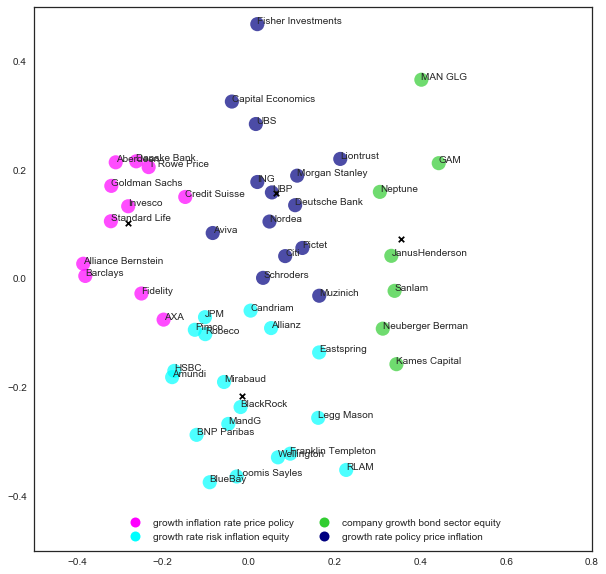

In [68]:
# visualise results

fig = plt.figure(figsize=(10,10))

sns.set_style("white")
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.xlim(-0.5,0.8)
plt.ylim(-0.5,0.5)
plt.rcParams.update({'font.size': 12})
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111)

ax1.scatter(red_df['X'], red_df['Y'], c=red_df['Colour'], marker='o', s=200,
            edgecolors='none', alpha=0.7,label='')
ax2.scatter(c['Centroid_x'], c['Centroid_y'], s=30, c='k', marker="x", label=c['Words'])

import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
import matplotlib.lines as mlines

line0 = mlines.Line2D([], [], color='magenta', marker='o', markersize=10, linestyle='None',label='')
line1 = mlines.Line2D([], [], color='cyan', marker='o', markersize=10, linestyle='None',label='')
line2 = mlines.Line2D([], [], color='limegreen', marker='o', markersize=10, linestyle='None', label='')
line3 = mlines.Line2D([], [], color='navy', marker='o', markersize=10, linestyle='None', label='')
line4 = mlines.Line2D([], [], color='gold', marker='o', markersize=10, linestyle='None', label='')
line5 = mlines.Line2D([], [], color='darkorange', marker='o', markersize=10, linestyle='None', label='')

ax2.legend([line0, line1, line2, line3, line4, line5],[c for c in c['Words']],
         loc = 'lower center', ncol=2, labelspacing=0.5)

for i in range(len(red_df)):
    ax1.text(red_df.ix[i]['X'], red_df.ix[i]['Y'], red_df.ix[i]['Names'], size=10)  

In [148]:
# use Latent Dirichlet Allocation for topic modelling

from gensim import corpora, models 

#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(clean_lems) ## this worked

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
#dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus_lda = [dictionary.doc2bow(text) for text in clean_lems] ## this worked


In [151]:
corpus_lda[0][0:10]


[(0, 3),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 3),
 (5, 1),
 (6, 1),
 (7, 4),
 (8, 1),
 (9, 1)]

In [ ]:
# build LDA model

lda = models.LdaModel(corpus_lda, num_topics=4, 
                            id2word=dictionary, 
                            update_every=5, 
                            chunksize=100, 
                            passes=1000)

In [ ]:
lda.show_topics()

In [ ]:
topics_matrix = lda.show_topics(formatted=True, num_words=10)

topics_matrix
raw = raw_text(topics_matrix)

In [ ]:
stuff = ["'", "+", '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '*', '.', '"', ',']

chars = [''.join([char for char in l if char not in stuff]) for l in raw]

topics = pd.DataFrame(chars, columns = ['Words'])

topics

In [ ]:
for w in topics.Words:
    print(w)